# Texture Processing

This is a tool to automatically specify a proper compression level for the given textures.

## Purpose

如果你像我一样也是个懒蛋，不想反复修改导入图片的compress level，那么可以交给脚本自动判断。贴图粗糙压缩损失率低，可以给一个高等级压缩；贴图精细压缩失真率高，则给一个低等级压缩

## Under the Hood

假设输入的图片都是线性空间的。

最简单的方法，直接在线性空间下计算压缩后的矩阵差，取Frobenius范数

这里的方法相对合理但比较主观，计算的是“视觉”空间下的损失函数。执行以下步骤：

1. gamma correction
2. 取a通道，计算卷积（laplacian算子）
3. 取rgb通道，灰值后，计算卷积（laplacian算子）
4. 取2和3的最大值与a通道加权，输出矩阵记为M
4. 模拟压缩，与原图相减，与M加权求和

对于亮度，人眼的感受需要在gamma空间下计算。


另，此计算方法基于假设：

* 对于一张图片，人眼总是更多关注细节多、对比度强的位置。因此2、3计算卷积作为权重
* 图片不经过缩放显示在游戏内

“视觉”兴趣区域结果：

![weight](weight.png)

细节度排序结果：

![result](result.png)

## Work Flow

to 加速，你需要joblib并行处理输入，可以把结果送到打包机redis上，通过c#获取结果，自行离散化输出，并于compress level一一对应（目前我是这样实现的）

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
textures = ["textures/"+f for f in os.listdir("textures")]
def plot_all(images):
    images = list(images)
    cnt = len(images)
    x = ceil(cnt**0.5)
    y = ceil(cnt/x)
    for i in range(cnt):
        img = images[i]
        if img is None:
            continue
        if not isinstance(img,Image.Image):
            img = Image.fromarray(img*255)
        plt.subplot(x,y,i+1)
        plt.imshow(img)
        plt.title(os.path.basename(textures[i]))
        plt.axis("off")

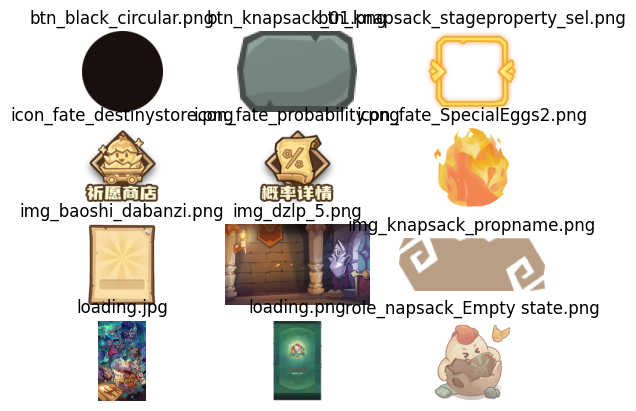

In [3]:
%matplotlib inline
from PIL import Image

def get_images(pathes):
    for p in pathes:
        img = Image.open(p)
        if img.mode!="RGBA":
            img = img.convert("RGBA")
        yield img
images_raw = list(get_images(textures))
plot_all(images_raw)



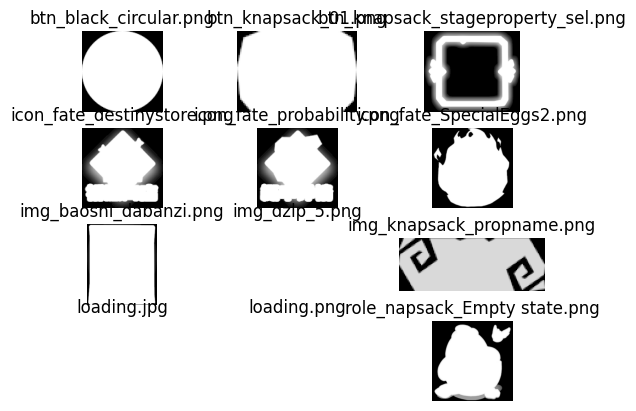

In [4]:
import numpy as np
REV_GAMMA = 1/2.2

images_channels = [
    img.split()
    for img in images_raw
]

    
gamma_a = [
    (np.array(channels[3])/255) ** REV_GAMMA
    for channels in images_channels
]
    

plot_all(gamma_a)


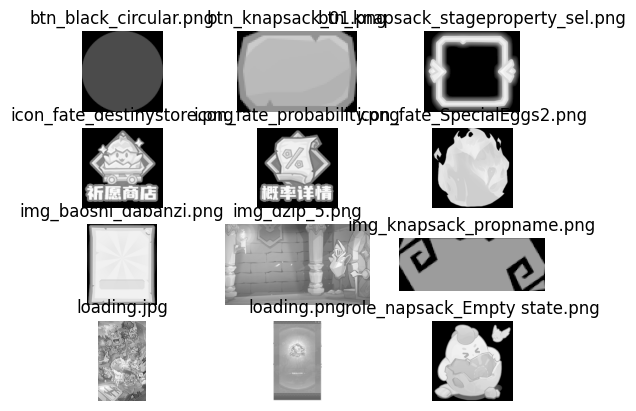

In [5]:
gamma_c = []

for i in range(len(images_channels)):
    channels = images_channels[i]
    a = gamma_a[i]

    arr_r = np.array(channels[0])/255
    arr_g = np.array(channels[1])/255
    arr_b = np.array(channels[2])/255
    
    arr_c = ((arr_r*0.3 + arr_g*0.6 + arr_b*0.1) **(1/2.2)) * a
    gamma_c.append(arr_c)
    
plot_all(gamma_c)


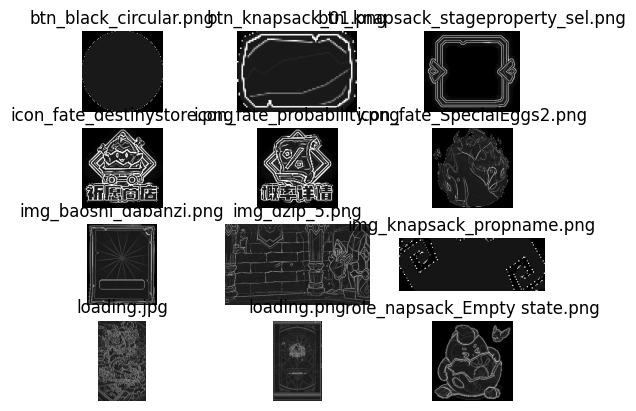

In [6]:
from PIL import ImageFilter,ImageMath
from scipy.signal import convolve2d
kernel = np.array([
    1, 1, 1,
    1,-8, 1,
    1, 1, 1,
]).reshape((3,3))

arr_ma = [
    np.clip((convolve2d(arr,kernel,mode="same")),0,1)
    for arr in gamma_a
]
arr_mc = [
    np.clip((convolve2d(arr,kernel,mode="same")),0,1)
    for arr in gamma_c
]
arr_weight_255 = [
    np.max(np.abs([ma, mc])+0.02,axis=0) * 5 * a
    # c
    for a,ma,mc in zip(gamma_a,arr_ma,arr_mc)
]

plot_all(arr_weight_255)

[0.005011542774599233, 0.011548860818871003, 0.011853286891608401, 0.024752037866712994, 0.026309736447991044, 0.03564568346013442, 0.04817711414006486, 0.0643726941018243, 0.0655880793115239, 0.07728165911829954, 0.14048200905431887, 0.46729311568120707]


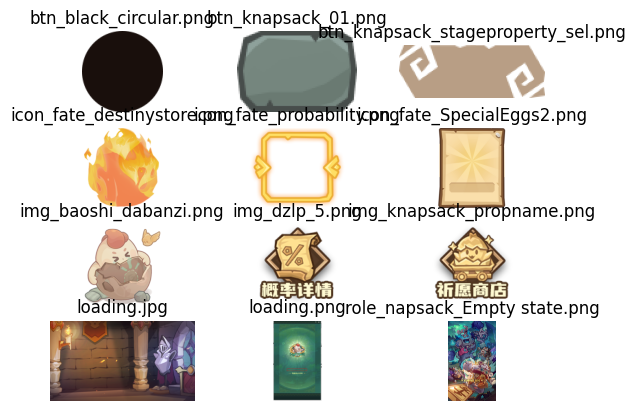

In [7]:

def down_size(t:tuple[int,int],level=1)->tuple[int,int]:
    return (max(1,t[0]>>level),max(1,t[1]>>level))
images_col = [
    Image.fromarray(c)
    for c in gamma_c
]
images_blur = [
    c.resize(down_size(c.size,3)).resize(c.size)
    for c in images_col
]
losses =[]
for i,c in enumerate(images_col):
    c = np.array(c)/255
    b = np.array(images_blur[i])/255
    m = arr_weight_255[i]
    losses.append( np.sum(((c-b)**2)*m)**0.5)
pairs = list(zip(losses,images_raw))
pairs.sort(key=lambda x:x[0])
plot_all([p[1] for p in pairs])
print([p[0] for p in pairs])
